In [1]:
import requests
import json
import time

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Plot Voronoi diagram for the stations to show approximate coverage of each.
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi,voronoi_plot_2d

%matplotlib inline

# Weather Data
There are many sources for weather data, but we chose to use the NOAA NCDC Integrated Surface Data, which is available on an hourly basis, and despite the archaic structure, is a very trustworthy source. This notebook shows how to parse and format this data. `isd-history.csv` was downloaded from the [NCDC website](ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv), but is provided in this repository.

In [2]:
stations = pd.read_csv('isd-history.csv',parse_dates=['BEGIN','END'])
# Weather records are queried by a concatenation of USAF and WBAN.
stations['station_id'] = stations.apply(lambda x: str(x['USAF'])+str(x['WBAN']), axis=1)
stations = stations.set_index('station_id')
stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
702699999,7026,99999,WXPOD 7026,AF,NaN,NaN,0.0,0.0,7026.0,2014-07-11,2017-08-22
707099999,7070,99999,WXPOD 7070,AF,NaN,NaN,0.0,0.0,7070.0,2014-09-23,2015-09-26
840399999,8403,99999,XM10,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-01,2014-04-12
841199999,8411,99999,XM20,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-02,2016-02-17
841499999,8414,99999,XM18,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-01,2016-02-17


In [3]:
utah_stations = stations[stations.STATE == 'UT']
utah_stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
69133499999,691334,99999,HILL/WENDOVER R GWC,US,UT,KQSL,41.050,-113.067,1299.0,1991-05-21,2003-08-16
69430099999,694300,99999,EAGLE RANGE &,US,UT,NaN,41.050,-113.067,1292.0,1980-04-23,1991-06-26
72056599999,720565,99999,HEBER CITY MUNICIPAL AIRPORT,US,UT,K36U,40.482,-111.429,1718.2,2010-04-12,2018-01-30
72056724180,720567,24180,BRIGHAM CITY AIRPORT,US,UT,KBMC,41.552,-112.062,1288.1,2014-07-24,2018-01-31
72056999999,720569,99999,KANAB MUNI,US,UT,KKNB,37.011,-112.531,1483.8,2013-08-13,2017-08-19


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
72470093141,724700,93141,CARBON COUNTY AIRPORT,US,UT,KPUC,39.609,-110.755,1804.7,2006-01-01,2018-01-31
72472099999,724720,99999,BLANDING,US,UT,NaN,37.617,-109.467,1840.0,1973-01-01,2018-01-29
72472393025,724723,93025,BLANDING MUNI,US,UT,K4BL,37.583,-109.483,1789.0,1990-02-08,2010-06-21
72473523170,724735,23170,HANKSVILLE,US,UT,KHVE,38.371,-110.715,1354.5,1973-01-01,2018-01-31
72475099999,724750,99999,MILFORD MUNICIPAL,US,UT,KMLF,38.417,-113.017,1536.0,1973-01-01,2018-01-15


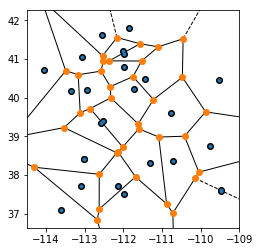

In [4]:
# Let's get stations that are valid for all of our time range. Not perfect, but we don't want to deal with interpolating missing data
start = pd.Timestamp(2010,1,1)
end = pd.Timestamp(2018,1,1)
valid_stations = utah_stations[(utah_stations.BEGIN < start) & (utah_stations.END > start)]
plt.figure()

lons = valid_stations.LON.values
lats = valid_stations.LAT.values
plt.plot(lons, lats,'ko')


vor = Voronoi(np.vstack((lons,lats)).T)
voronoi_plot_2d(vor,ax=plt.gca())
plt.gca().set_aspect(1)
valid_stations.head()

In [5]:
stations = valid_stations.index.values.tolist()
valid_stations.to_csv('utah_stations.csv')

## Pulling weather data.
Mostly self explanatory, see [API docs](https://www.ncei.noaa.gov/support/access-data-service-api-user-documentation) for more details. The dataType codes are documented 
[here](ftp://ftp.ncdc.noaa.gov/pub/data/noaa/ish-format-document.pdf)

In [6]:
url = 'https://www.ncdc.noaa.gov/access-data-service/api/v1/data'

params = {
    'dataset': 'global-hourly',
    'startDate': '2010-01-01T00:00:00',
    'endDate': '2018-02-01T00:00:00',
    'dataTypes':'AA1,AA1,AA2,AA3,TMP,VIS,WND,AJ1,AT1,AT2,AT3,AT4,AT5,AT6,AT7,AT8',
    'stations': stations,
    'format': 'json'
    
}

weather_data = pd.DataFrame()

for station in stations:
    params['stations'] = station
    print('Station:',station)
    res = requests.get(url,params=params)
    js = res.json()
    print(len(js))
    try:
        weather_data = weather_data.append(js)
    except:
        print ("Empty for station",station)
    time.sleep(0.5)


Station: 72470093141
82095
Station: 72472099999
6351
Station: 72472393025
3
Station: 72473523170
84478
Station: 72475099999
42168
Station: 72475423186
164113
Station: 72475593129
84393
Station: 72475623159
92246
Station: 72477693075
80793
Station: 72479599999
6760
Station: 72479694128
92932
Station: 72479723176
98930
Station: 72570594030
84736
Station: 72572024127
107223
Station: 72572424174
125742
Station: 72575024126
86423
Station: 72575399999
24930
Station: 72575524101
117983
Station: 72581024193
186734
Station: 74003024103
7227
Station: 9999993081
0
Empty for station 9999993081
Station: 9999994133
0
Empty for station 9999994133
Station: 9999994134
0
Empty for station 9999994134
Station: 9999994138
0
Empty for station 9999994138
Station: 99999923162
86596
Station: 99999953149
818771


In [7]:
weather_data.head()
weather_data.to_csv('utah_weather_2010-2018_raw.csv')

## Extracting/Converting Weather Features
As mentioned before, the format specification has been around a while. This block reformats the data in a useful format. 

In [8]:

def parseWindDir(x):
    # Wind direction, deg or 999
    d = x.split(',')[0]
    if d == '999':
        return np.nan
    return float(d)


def parseWindSpeed(x):
    s = x.split(',')[3]
    if s == '9999':
        return 0.0
    return float(s) / 10.0

def parseVisibility(x):
    v = x.split(',')[0]
    if v == '999999':
        return 16093.0
    return float(v)

def parseTemp(x):
    t = x.split(',')[0]
    if t == '+9999':
        return np.nan
    return float(t) / 10.0

def parseSnowDepth(x):
    try:
        t = x.split(',')[0]
    except:
        return 0.0

    if t == '9999':
        return 0.0
    return float(t) 

def parsePrecip(x):
    try:
        p = x.split(',')[1]
        return float(p) / 10.0
    except:
        return 0.0

weather_lut = {
    '01': 'fog',
    '02': 'fog',
    '03': 'thunder',
    '04': 'sleet/hail',
    '05': 'hail',
    '06': 'glaze',
    '07': 'dust',
    '08': 'smoke',
    '09': 'blowing_snow',
    '10': 'tornado',
    '11': 'winds',
    '12': 'spray',
    '13': 'mist',
    '14': 'drizzle',
    '15': 'freezing_drizzle',
    '16': 'rain',
    '17': 'freezing_rain',
    '18': 'snow',
    '19': 'unknown_precipitation',
    '21': 'ground_fog',
    '22': 'ice_fog'
}
def parseWeatherType(x):
    try:
        p = x.split(',')[1]
    except:
        return x
    return weather_lut[p]
        
    
weather_data['DATE'] = pd.to_datetime(weather_data["DATE"])
weather_data['wind_dir'] = weather_data.WND.apply(parseWindDir)
weather_data['wind_speed'] = weather_data.WND.apply(parseWindSpeed)
weather_data['visibility'] = weather_data.VIS.apply(parseVisibility)
weather_data['temperature'] = weather_data.TMP.apply(parseTemp)
weather_data['precip_01'] = weather_data.AA1.apply(parsePrecip)
weather_data['precip_02'] = weather_data.AA2.apply(parsePrecip)
weather_data['precip_03'] = weather_data.AA3.apply(parsePrecip)
weather_data['precip_depth'] = weather_data[['precip_01','precip_02','precip_03']].max(axis=1)
weather_data['snow_depth'] = weather_data.AJ1.apply(parseSnowDepth)
weather_data['AT1'] = weather_data.AT1.apply(parseWeatherType)
weather_data['AT2'] = weather_data.AT2.apply(parseWeatherType)
weather_data['AT3'] = weather_data.AT3.apply(parseWeatherType)
weather_data['AT4'] = weather_data.AT4.apply(parseWeatherType)
weather_data['AT5'] = weather_data.AT5.apply(parseWeatherType)
weather_data['AT6'] = weather_data.AT6.apply(parseWeatherType)
weather_data['AT7'] = weather_data.AT7.apply(parseWeatherType)
weather_data['AT8'] = weather_data.AT8.apply(parseWeatherType)

weather_types = weather_data[['AT1','AT2','AT3','AT4','AT5','AT6','AT7','AT8']]

weather_data['snowing'] = weather_types.apply(lambda x: x.isin(['snow'])).any(axis=1)
weather_data['raining'] = weather_types.apply(lambda x: x.isin(['rain','freezing_rain','drizzle','freezing_drizzle'])).any(axis=1)
weather_data['foggy'] = weather_types.apply(lambda x: x.isin(['fog','ground_fog','ice_fog'])).any(axis=1)
weather_data['thunderstorm'] = weather_types.apply(lambda x: x.str.contains('thunder')).any(axis=1)
weather_data['hailing'] = weather_types.apply(lambda x: x.isin(['sleet/hail','hail'])).any(axis=1)
weather_data['icy'] = weather_types.apply(lambda x: x.isin(['glaze','freezing_rain,freezing_drizzle','ice_fog','snow'])).any(axis=1)
weather_data['station_id'] = weather_data.STATION

# Drop parsed columns
weather_data = weather_data.drop(['WND','VIS','AA1','AA2','AA3','precip_01','precip_02','precip_03','AJ1'],axis=1)
weather_data = weather_data.drop(['TMP','AT1','AT2','AT3','AT4','AT5','AT6','AT7','AT8','SOURCE','REPORT_TYPE','QUALITY_CONTROL','STATION'],axis=1)

In [9]:
weather_data.head()

,DATE,wind_dir,wind_speed,visibility,temperature,precip_depth,snow_depth,snowing,raining,foggy,thunderstorm,hailing,icy,station_id
0,2010-01-01 00:53:00,40.0,2.1,16093.0,-11.7,0.0,0.0,False,False,False,False,False,False,72470093141
1,2010-01-01 01:53:00,30.0,2.6,16093.0,-11.7,0.0,0.0,False,False,False,False,False,False,72470093141
2,2010-01-01 02:53:00,40.0,2.1,16093.0,-12.2,0.0,0.0,False,False,False,False,False,False,72470093141
3,2010-01-01 03:53:00,40.0,2.6,16093.0,-11.7,0.0,0.0,False,False,False,False,False,False,72470093141
4,2010-01-01 04:53:00,40.0,2.1,16093.0,-9.4,0.0,0.0,False,False,False,False,False,False,72470093141


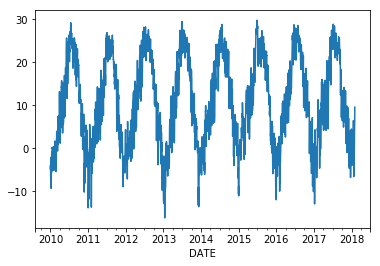

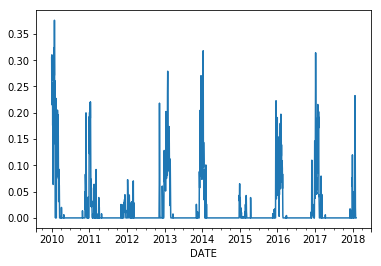

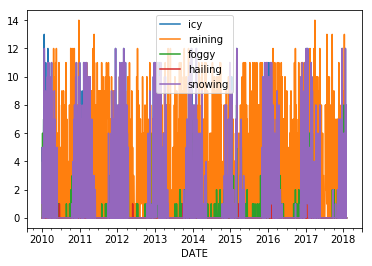

In [10]:
ts = weather_data.set_index('DATE').temperature.resample('1d').mean()
ts.plot()
ts = weather_data.set_index('DATE').snow_depth.resample('1d').mean()
plt.figure()
ts.plot()
ts = weather_data.set_index('DATE')[['icy','raining','foggy','hailing','snowing']].resample('1d').sum()
plt.figure()
ts.plot()

In [12]:
weather_data.to_csv('utah_weather_2010-2018.csv')
weather_data = pd.read_csv('utah_weather_2010-2018.csv',index_col=0)
weather_data.head()

,DATE,wind_dir,wind_speed,visibility,temperature,precip_depth,snow_depth,snowing,raining,foggy,thunderstorm,hailing,icy,station_id
0,2010-01-01 00:53:00,40.0,2.1,16093.0,-11.7,0.0,0.0,False,False,False,False,False,False,72470093141
1,2010-01-01 01:53:00,30.0,2.6,16093.0,-11.7,0.0,0.0,False,False,False,False,False,False,72470093141
2,2010-01-01 02:53:00,40.0,2.1,16093.0,-12.2,0.0,0.0,False,False,False,False,False,False,72470093141
3,2010-01-01 03:53:00,40.0,2.6,16093.0,-11.7,0.0,0.0,False,False,False,False,False,False,72470093141
4,2010-01-01 04:53:00,40.0,2.1,16093.0,-9.4,0.0,0.0,False,False,False,False,False,False,72470093141


In [13]:
weather_data['timestamp'] = pd.to_datetime(weather_data.DATE)

In [14]:
time_index = pd.DatetimeIndex(weather_data['timestamp'])

## Aggregate weather to hourly bins
No real magic here, but the weather conditions like raining, snowing, etc are reported on a daily basis, so these are aggregated over a 24 hour sliding window. 

In [15]:
aggs = {
    'snowing': 'any',
    'raining': 'any',
    'foggy': 'any',
    'icy': 'any',
    'hailing': 'any',
    'thunderstorm':'any',
    'wind_speed': 'mean',
    'visibility': 'mean',
    'temperature': 'mean',
    'precip_depth':'mean',
    'snow_depth':'mean'
}

In [17]:
resamp = pd.DataFrame()
station_ids = list(set(weather_data.station_id.tolist()))
for _id in station_ids:
    idx = weather_data.station_id == _id
    ti = time_index[idx]

    wdfi = weather_data[idx].set_index(ti)
    floating = wdfi[['visibility','temperature','wind_speed','precip_depth','snow_depth']]
    binaries = wdfi[['snowing','raining','foggy','icy','hailing','thunderstorm']]
    b = binaries.resample('1h').rolling(24).apply(lambda x: x.any())
    f = floating.resample('1h').agg({
        'wind_speed': 'mean',
        'visibility': 'mean',
        'temperature': 'mean',
        'precip_depth':'mean',
        'snow_depth':'mean'
    })

    temp = pd.concat((f,b),axis=1)
    temp['station_id'] = _id
    resamp = resamp.append(temp)


In [18]:
for f in ['visibility','temperature','wind_speed','precip_depth','snow_depth']:
    resamp.loc[pd.isna(resamp[f]),f] = np.nanmedian(resamp[f])
for f in ['snowing','raining','foggy','icy','hailing','thunderstorm']:
    resamp.loc[pd.isna(resamp[f]),f] = 0

In [19]:
resamp.reset_index().set_index(['timestamp','station_id']).to_csv('utah_weather_2010-2018_grouped.csv')